# Data overview

The dataset consists of set of minifigures. Let's check this out!

# Let's try to write dataset wrapper for data

In [ ]:
import os
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        
        # Collect all image paths
        for path in self.root_dir.iterdir():
            if path.is_file():
                self.image_paths.append(path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Convert to RGB
        
        if self.transform:
            image = self.transform(image)
            
        return image
    
dataset = ImageDataset("./lego_professions")

# Base knowledges

In [633]:
len(dataset)

3998

So, dataset consists of 3998 lego minifigures. Let's try to see some examples

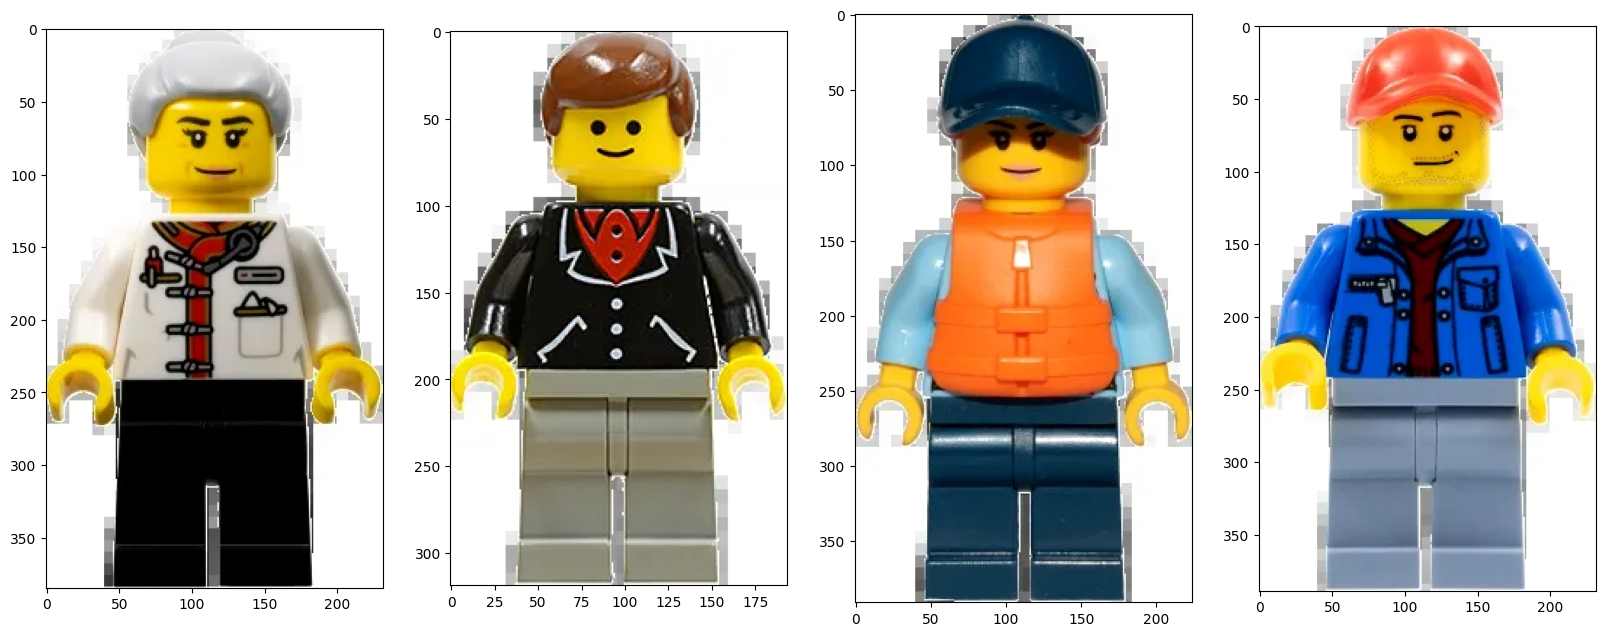

In [634]:
import numpy as np
import matplotlib.pyplot as plt

K = 4

indicies = np.random.randint(len(dataset), size=K)

fig, ax = plt.subplots(1, K, figsize=(20, 20))

for k in range(K):
    ax[k].imshow(dataset[indicies[k]])

plt.show()

(array([  1.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   2.,
          1.,   2.,   1.,   1.,   5.,   4.,   2.,   3.,   4.,  12.,   7.,
          7.,   3.,  12.,  18.,  10.,  17.,  12.,  17.,  12.,  40.,  46.,
         51.,  40.,  86., 106., 120.,  97.,  31.,  37.,  52.,  43.,  40.,
         87.,  87., 137.,  90., 150., 182., 297., 348., 254., 320., 410.,
        170.,  85.,  89.,  48.,  26.,   8.,  14.,  25.,  22.,  22.,  16.,
         28.,  30.,  27.,  13.,  14.,  26.,   8.,   4.,   4.,   5.,   3.,
          0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([ 88.  ,  90.77,  93.54,  96.31,  99.08, 101.85, 104.62, 107.39,
        110.16, 112.93, 115.7 , 118.47, 121.24, 124.01, 126.78, 129.55,
        132.32, 135.09, 137.86, 140.63, 143.4 , 146.17, 148.94, 151.71,
        154.48, 157.25, 160.02, 162.79, 165.56, 168.33, 171.1 , 173.87,
        176.64, 179.41, 182.18

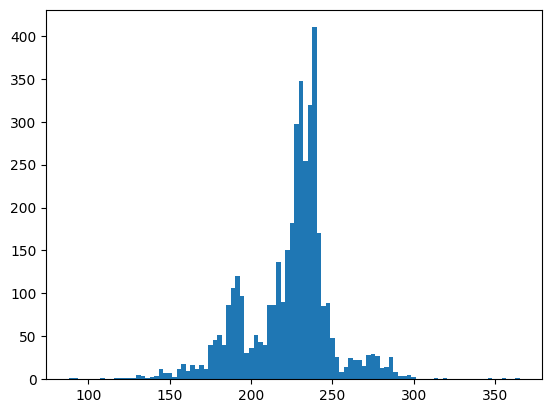

In [635]:
import matplotlib.pyplot as plt

heights = [image.size[0] for image in dataset]
widths = [image.size[1] for image in dataset]

plt.hist(heights, bins=100)

So, we have four specifications of dataset

1. Dataset consists of various minifigures, which can be in various positions
2. Dataset has no background
3. Dataset is unsupervised and consists only life-size minifigures

# Preprocess images

We have two things to do:

1. Crop minifigures to only faces
2. Replace background with some life versions

Let's start with first one

In order to approximate head we can firstly crop image

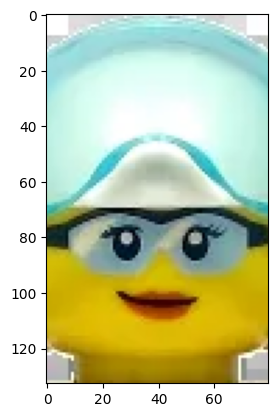

In [636]:
from torchvision.transforms import ToTensor
from PIL import Image


def crop_image(tensor_image):
    tensor_image = tensor_image[:, :tensor_image.shape[1] // 3, tensor_image.shape[2] // 3 : 2 * tensor_image.shape[2] // 3]

    return tensor_image

tensor_image = crop_image(ToTensor()(dataset[78]))
plt.imshow(tensor_image.permute(1, 2, 0))


This works pretty well, however, after that we have outliers like this

In [637]:
from facenet_pytorch import MTCNN, InceptionResnetV1

# If required, create a face detection pipeline using MTCNN:
mtcnn = MTCNN(select_largest=False, device='cuda:0')

# Create an inception resnet (in eval mode):
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [638]:
import torch.nn.functional as F
import torch
import tqdm

def calc_embedding(index: int):

    h, w = dataset[index].size[0], dataset[index].size[1]

    tensor_image = ToTensor()(dataset[index])

    print(tensor_image.shape)

    image_cropped = mtcnn.detect(torch.permute(tensor_image, (1, 2, 0)) * 255.0)

    return image_cropped

recognized_face_indexes = []

for k in tqdm.trange(len(dataset)):
    res = calc_embedding(k)
    if res[0] is not None:
        recognized_face_indexes.append(k)
        print(k)
        if k > 200:
            break


  0%|          | 2/3998 [00:00<05:06, 13.02it/s]

torch.Size([3, 387, 268])
torch.Size([3, 377, 233])
torch.Size([3, 377, 225])


  0%|          | 6/3998 [00:00<04:08, 16.04it/s]

torch.Size([3, 381, 227])
torch.Size([3, 387, 236])
torch.Size([3, 388, 229])
torch.Size([3, 391, 234])


  0%|          | 10/3998 [00:00<03:49, 17.39it/s]

torch.Size([3, 382, 221])
torch.Size([3, 400, 239])
torch.Size([3, 315, 187])
torch.Size([3, 390, 231])


  0%|          | 14/3998 [00:00<03:40, 18.07it/s]

torch.Size([3, 309, 220])
torch.Size([3, 315, 198])
torch.Size([3, 391, 199])
torch.Size([3, 400, 246])


  0%|          | 18/3998 [00:01<03:44, 17.73it/s]

torch.Size([3, 362, 224])
torch.Size([3, 392, 228])
torch.Size([3, 347, 197])
torch.Size([3, 364, 195])


  1%|          | 23/3998 [00:01<03:32, 18.71it/s]

torch.Size([3, 394, 236])
torch.Size([3, 387, 178])
torch.Size([3, 384, 217])
torch.Size([3, 278, 173])


  1%|          | 25/3998 [00:01<03:43, 17.75it/s]

torch.Size([3, 383, 232])
torch.Size([3, 392, 237])
torch.Size([3, 375, 233])
torch.Size([3, 368, 224])


  1%|          | 29/3998 [00:01<03:48, 17.37it/s]

torch.Size([3, 396, 246])
torch.Size([3, 380, 238])
torch.Size([3, 389, 236])
torch.Size([3, 318, 235])


  1%|          | 33/3998 [00:01<03:46, 17.53it/s]

torch.Size([3, 317, 239])
torch.Size([3, 399, 244])
torch.Size([3, 318, 177])
torch.Size([3, 399, 245])


  1%|          | 37/3998 [00:02<03:48, 17.34it/s]

torch.Size([3, 396, 233])
torch.Size([3, 315, 231])
torch.Size([3, 376, 219])
torch.Size([3, 351, 204])


  1%|          | 41/3998 [00:02<03:43, 17.74it/s]

torch.Size([3, 317, 237])
torch.Size([3, 376, 230])
torch.Size([3, 314, 190])
41
torch.Size([3, 392, 233])


  1%|          | 45/3998 [00:02<03:35, 18.34it/s]

torch.Size([3, 296, 217])
torch.Size([3, 386, 235])
torch.Size([3, 386, 249])
torch.Size([3, 387, 227])


  1%|          | 49/3998 [00:02<03:33, 18.51it/s]

torch.Size([3, 314, 211])
torch.Size([3, 400, 231])
torch.Size([3, 316, 196])
torch.Size([3, 318, 207])


  1%|▏         | 54/3998 [00:03<03:33, 18.45it/s]

torch.Size([3, 393, 240])
torch.Size([3, 384, 227])
torch.Size([3, 386, 243])
torch.Size([3, 387, 202])


  1%|▏         | 58/3998 [00:03<03:28, 18.93it/s]

torch.Size([3, 392, 226])
torch.Size([3, 316, 203])
torch.Size([3, 395, 236])
torch.Size([3, 316, 224])


  2%|▏         | 62/3998 [00:03<03:28, 18.92it/s]

torch.Size([3, 379, 285])
torch.Size([3, 357, 208])
torch.Size([3, 371, 224])
torch.Size([3, 389, 240])


  2%|▏         | 66/3998 [00:03<03:36, 18.14it/s]

torch.Size([3, 400, 202])
torch.Size([3, 352, 212])
torch.Size([3, 377, 229])
torch.Size([3, 375, 231])


  2%|▏         | 70/3998 [00:03<03:30, 18.67it/s]

torch.Size([3, 391, 238])
torch.Size([3, 389, 280])
torch.Size([3, 315, 212])
torch.Size([3, 400, 236])


  2%|▏         | 74/3998 [00:04<03:51, 16.97it/s]

torch.Size([3, 385, 233])
torch.Size([3, 392, 277])
torch.Size([3, 390, 229])


  2%|▏         | 76/3998 [00:04<03:52, 16.86it/s]

torch.Size([3, 379, 228])
torch.Size([3, 386, 228])
torch.Size([3, 385, 210])
torch.Size([3, 378, 225])


  2%|▏         | 81/3998 [00:04<03:32, 18.45it/s]

torch.Size([3, 400, 240])
torch.Size([3, 386, 220])
torch.Size([3, 393, 226])
torch.Size([3, 386, 233])


  2%|▏         | 85/3998 [00:04<03:28, 18.73it/s]

81
torch.Size([3, 304, 183])
torch.Size([3, 397, 232])
torch.Size([3, 368, 220])
torch.Size([3, 315, 192])


  2%|▏         | 89/3998 [00:04<03:27, 18.83it/s]

torch.Size([3, 318, 195])
torch.Size([3, 388, 215])
torch.Size([3, 378, 239])
torch.Size([3, 384, 228])


  2%|▏         | 94/3998 [00:05<03:20, 19.48it/s]

torch.Size([3, 387, 245])
torch.Size([3, 312, 194])
torch.Size([3, 311, 181])
torch.Size([3, 382, 227])


  2%|▏         | 97/3998 [00:05<03:20, 19.48it/s]

torch.Size([3, 385, 232])
torch.Size([3, 317, 197])
torch.Size([3, 387, 230])
torch.Size([3, 392, 235])


  2%|▏         | 99/3998 [00:05<03:33, 18.28it/s]

torch.Size([3, 377, 228])
torch.Size([3, 306, 181])
torch.Size([3, 313, 150])
torch.Size([3, 396, 250])


  3%|▎         | 105/3998 [00:05<03:21, 19.34it/s]

torch.Size([3, 315, 192])
torch.Size([3, 290, 177])
torch.Size([3, 380, 227])
104
torch.Size([3, 267, 168])


  3%|▎         | 109/3998 [00:06<03:38, 17.82it/s]

torch.Size([3, 378, 268])
torch.Size([3, 382, 236])
107
torch.Size([3, 397, 237])
108
torch.Size([3, 384, 234])


  3%|▎         | 113/3998 [00:06<03:43, 17.37it/s]

torch.Size([3, 392, 228])
110
torch.Size([3, 291, 176])
torch.Size([3, 307, 187])
torch.Size([3, 389, 234])


  3%|▎         | 118/3998 [00:06<03:26, 18.78it/s]

torch.Size([3, 313, 191])
torch.Size([3, 315, 192])
torch.Size([3, 383, 235])
torch.Size([3, 316, 190])
torch.Size([3, 385, 218])


  3%|▎         | 120/3998 [00:06<03:29, 18.54it/s]

torch.Size([3, 392, 273])
torch.Size([3, 312, 190])
120
torch.Size([3, 303, 182])
torch.Size([3, 393, 285])


  3%|▎         | 125/3998 [00:06<03:32, 18.24it/s]

torch.Size([3, 336, 198])
torch.Size([3, 396, 252])
124
torch.Size([3, 383, 233])
torch.Size([3, 382, 232])


  3%|▎         | 129/3998 [00:07<03:41, 17.49it/s]

torch.Size([3, 387, 230])
torch.Size([3, 395, 246])
128
torch.Size([3, 315, 187])
torch.Size([3, 396, 248])


  3%|▎         | 133/3998 [00:07<03:45, 17.12it/s]

torch.Size([3, 368, 222])
131
torch.Size([3, 387, 217])
torch.Size([3, 379, 286])
torch.Size([3, 386, 226])


  3%|▎         | 137/3998 [00:07<03:45, 17.11it/s]

torch.Size([3, 388, 238])
torch.Size([3, 318, 237])
torch.Size([3, 391, 198])
torch.Size([3, 315, 190])


  4%|▎         | 141/3998 [00:07<03:44, 17.18it/s]

torch.Size([3, 317, 236])
torch.Size([3, 382, 234])
torch.Size([3, 393, 244])
torch.Size([3, 381, 222])


  4%|▎         | 145/3998 [00:08<03:37, 17.68it/s]

torch.Size([3, 315, 239])
143
torch.Size([3, 394, 230])
torch.Size([3, 381, 226])
torch.Size([3, 399, 230])


  4%|▎         | 149/3998 [00:08<03:41, 17.40it/s]

torch.Size([3, 375, 231])
torch.Size([3, 382, 221])
torch.Size([3, 305, 216])
torch.Size([3, 390, 232])


  4%|▍         | 154/3998 [00:08<03:31, 18.21it/s]

150
torch.Size([3, 317, 182])
torch.Size([3, 315, 192])
torch.Size([3, 393, 224])
torch.Size([3, 380, 225])


  4%|▍         | 158/3998 [00:08<03:37, 17.62it/s]

torch.Size([3, 383, 248])
155
torch.Size([3, 318, 231])
torch.Size([3, 382, 296])
torch.Size([3, 373, 229])


  4%|▍         | 163/3998 [00:09<03:25, 18.67it/s]

torch.Size([3, 317, 231])
torch.Size([3, 340, 206])
torch.Size([3, 380, 222])
torch.Size([3, 382, 232])
torch.Size([3, 373, 225])


  4%|▍         | 167/3998 [00:09<03:31, 18.13it/s]

torch.Size([3, 395, 275])
torch.Size([3, 311, 186])
torch.Size([3, 394, 242])
torch.Size([3, 393, 276])


  4%|▍         | 171/3998 [00:09<03:34, 17.80it/s]

torch.Size([3, 398, 286])
torch.Size([3, 394, 232])
torch.Size([3, 391, 245])
torch.Size([3, 394, 235])


  4%|▍         | 175/3998 [00:09<03:33, 17.87it/s]

torch.Size([3, 317, 188])
torch.Size([3, 385, 239])
torch.Size([3, 390, 180])
torch.Size([3, 386, 242])


  4%|▍         | 179/3998 [00:09<03:29, 18.20it/s]

torch.Size([3, 315, 192])
torch.Size([3, 378, 229])
torch.Size([3, 389, 233])
torch.Size([3, 394, 241])


  5%|▍         | 183/3998 [00:10<03:41, 17.25it/s]

torch.Size([3, 390, 199])
torch.Size([3, 392, 236])
181
torch.Size([3, 278, 167])
torch.Size([3, 400, 226])


  5%|▍         | 187/3998 [00:10<03:51, 16.49it/s]

torch.Size([3, 371, 204])
torch.Size([3, 317, 240])
torch.Size([3, 383, 227])
torch.Size([3, 370, 257])


  5%|▍         | 191/3998 [00:10<03:49, 16.61it/s]

torch.Size([3, 390, 287])
torch.Size([3, 380, 241])
torch.Size([3, 227, 218])
torch.Size([3, 382, 240])


  5%|▍         | 195/3998 [00:10<03:35, 17.68it/s]

torch.Size([3, 377, 223])
torch.Size([3, 382, 230])
torch.Size([3, 382, 238])
torch.Size([3, 392, 233])


  5%|▍         | 199/3998 [00:11<03:35, 17.65it/s]

torch.Size([3, 379, 223])
torch.Size([3, 397, 239])
torch.Size([3, 398, 231])
torch.Size([3, 392, 229])


  5%|▌         | 201/3998 [00:11<03:34, 17.73it/s]

torch.Size([3, 394, 274])
torch.Size([3, 385, 277])
201


In [640]:
recognized_face_indexes

[41, 81, 104, 107, 108, 110, 120, 124, 128, 131, 143, 150, 155, 181, 201]

In [641]:
len(recognized_face_indexes)
recognized_face_indexes[5]

110

In [642]:

def get_index(index):
    embedding = calc_embedding(recognized_face_indexes[index])[0]
    print(embedding)
    coords = embedding[0]

    image = ToTensor()(dataset[recognized_face_indexes[index]])
    print(image.size())

    for i in range(4):
        if coords[i] < 0:
            coords[i] = 0

    print(coords)

    x, y, x1, y1 = coords[0], coords[1], coords[2], coords[3]

    if x > x1:
        x, x1 = x1, x
    if y > y1:
        y, y1 = y1, y

    print(x, y, x1, y1)

    image = image[:, int(y):int(y1), int(x):int(x1)]

    print(image.shape)
    
    return image

get_index(2)

torch.Size([3, 380, 227])
[[83.29207611083984 69.77584075927734 101.70931243896484
  93.17434692382812]]
torch.Size([3, 380, 227])
[83.29207611083984 69.77584075927734 101.70931243896484 93.17434692382812]
83.29207611083984 69.77584075927734 101.70931243896484 93.17434692382812
torch.Size([3, 24, 18])


tensor([[[0.2824, 0.2039, 0.1843,  ..., 0.2549, 0.2510, 0.2863],
         [0.2667, 0.2392, 0.3686,  ..., 0.4196, 0.2314, 0.2784],
         [0.2353, 0.3412, 0.5843,  ..., 0.7098, 0.5098, 0.2510],
         ...,
         [0.6196, 0.8510, 0.8784,  ..., 0.8078, 0.8745, 0.8471],
         [0.3961, 0.7804, 0.8863,  ..., 0.8667, 0.8706, 0.9294],
         [0.3216, 0.4353, 0.8980,  ..., 0.9098, 0.9020, 0.9529]],

        [[0.0510, 0.0000, 0.0000,  ..., 0.0196, 0.0118, 0.0314],
         [0.0157, 0.0039, 0.1529,  ..., 0.2039, 0.0000, 0.0353],
         [0.0000, 0.1059, 0.3725,  ..., 0.5294, 0.3059, 0.0314],
         ...,
         [0.3843, 0.6667, 0.7255,  ..., 0.7451, 0.7725, 0.7098],
         [0.1451, 0.5686, 0.7098,  ..., 0.7686, 0.7451, 0.7608],
         [0.0549, 0.2000, 0.6824,  ..., 0.7765, 0.7412, 0.7490]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0353, 0.0118, 0.0118],
         [0.0196, 0.0314, 0.1647,  ..., 0.2078, 0.0118, 0.0471],
         [0.0000, 0.1216, 0.3608,  ..., 0.5020, 0.2941, 0.

[ 0 14 12  0]
41
torch.Size([3, 314, 190])
[[71.40939331054688 31.661930084228516 121.57752990722656
  88.65238189697266]]
torch.Size([3, 314, 190])
[71.40939331054688 31.661930084228516 121.57752990722656 88.65238189697266]
71.40939331054688 31.661930084228516 121.57752990722656 88.65238189697266
torch.Size([3, 57, 50])
201
torch.Size([3, 385, 277])
[[104.9273910522461 48.81781768798828 182.33297729492188
  140.94737243652344]]
torch.Size([3, 385, 277])
[104.9273910522461 48.81781768798828 182.33297729492188 140.94737243652344]
104.9273910522461 48.81781768798828 182.33297729492188 140.94737243652344
torch.Size([3, 92, 78])
155
torch.Size([3, 383, 248])
[[196.35836791992188 52.1894416809082 234.4113006591797 99.4643325805664]
 [81.14268493652344 42.162696838378906 152.59078979492188
  134.95059204101562]]
torch.Size([3, 383, 248])
[196.35836791992188 52.1894416809082 234.4113006591797 99.4643325805664]
196.35836791992188 52.1894416809082 234.4113006591797 99.4643325805664
torch.Size([

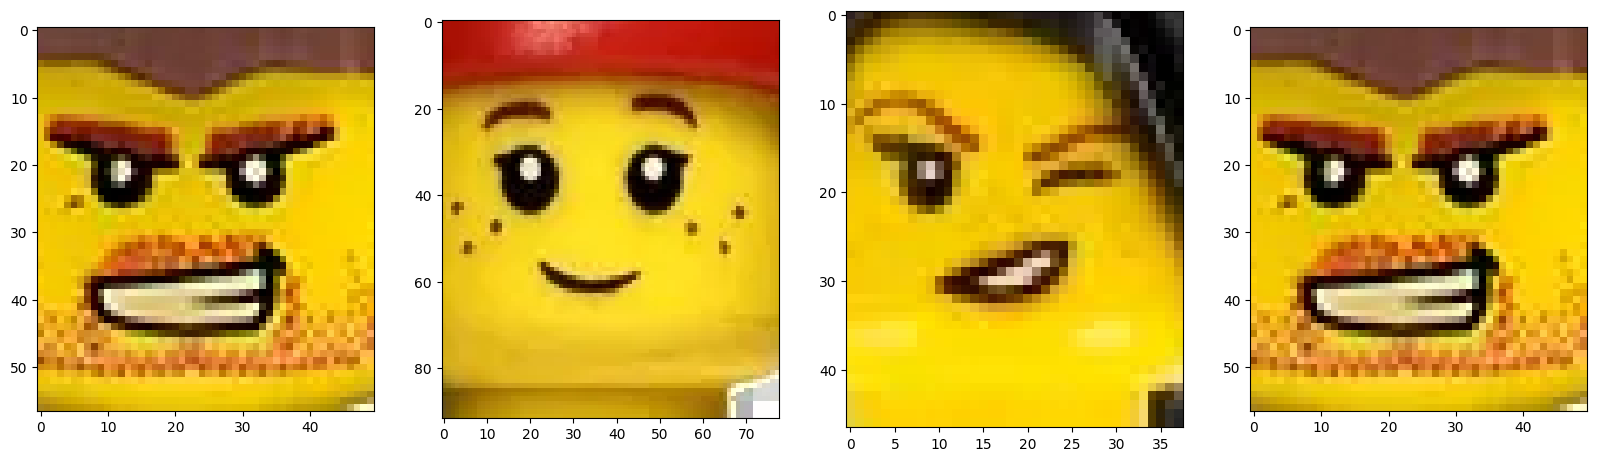

In [658]:
indicies = np.random.randint(len(recognized_face_indexes), size=K)

print(indicies)

fig, ax = plt.subplots(1, K, figsize=(20, 20))

for k in range(K):
    print(recognized_face_indexes[indicies[k]])
    ax[k].imshow(get_index(indicies[k]).permute(1, 2, 0))

Awesome! We've get a good pipeline to crop minifigures heads.

Let's try to wrap it in detection pipeline

In [ ]:
import torchvision

class FaceDetector:
    def __init__(self, device, optimal_image_size):
        # Initializes detector
        self.mtcnn = MTCNN(select_largest=False, image_size=optimal_image_size, margin=0, min_face_size=100, thresholds=[0.7, 0.7, 0.7], device=device)
        self.resnet = InceptionResnetV1(pretrained='vggface2').eval()

        self.optimal_image_size = optimal_image_size

        if optimal_image_size is not None:
            self.resize = torchvision.transforms.Resize((self.optimal_image_size, self.optimal_image_size))
        
    def get_coords_and_embeds(self, image):
        # Gets bounding boxed for one tensor image
        # Returns Nones for images without faces
        # Otherwise returns coords and ebmeddings for image

        h, w = image.shape[1], image.shape[2]

        # According to original facenet lib, we should reshape image to size (160, 160)
        # In order to get higher accuracy of detection

        if self.optimal_image_size is not None:
            image = self.resize(image)

        h1, w1 = image.shape[1], image.shape[2]

        forward_image = torch.permute(image, (1, 2, 0)) * 255.0

        image_cropped = self.mtcnn.detect(forward_image)

        if self.mtcnn(forward_image) is not None:
            image_embedding = self.resnet(self.mtcnn(forward_image).unsqueeze(0))

        bounding_box = image_cropped[0]

        if bounding_box is None:
            return None
        else:

            print("!!!", bounding_box.shape[0])

            result_bounding_box = bounding_box[0]

            if self.optimal_image_size is not None:
                
                result_bounding_box[0] *= h / self.optimal_image_size
                result_bounding_box[2] *= h / self.optimal_image_size
                
                result_bounding_box[1] *= w / self.optimal_image_size
                result_bounding_box[3] *= w / self.optimal_image_size

            return result_bounding_box, image_embedding[0].detach().numpy()


face_detector = FaceDetector("cuda", 256)

In [864]:
from torch.utils.data import Dataset
from torchvision.io import read_image

tensor_dataset = ImageDataset("./lego_professions", transform=lambda x: torchvision.transforms.ToTensor()(x))
tensor_dataset[0]

tensor([[[0.9686, 0.9725, 0.9765,  ..., 0.1608, 0.1412, 0.1333],
         [0.9686, 0.9725, 0.9765,  ..., 0.1569, 0.1412, 0.1333],
         [0.9686, 0.9725, 0.9765,  ..., 0.1569, 0.1412, 0.1333],
         ...,
         [0.6667, 0.6667, 0.6667,  ..., 0.7255, 0.7216, 0.7216],
         [0.6431, 0.6431, 0.6392,  ..., 0.7216, 0.7216, 0.7176],
         [0.6275, 0.6235, 0.6196,  ..., 0.7176, 0.7176, 0.7137]],

        [[0.6275, 0.6314, 0.6353,  ..., 0.0745, 0.0667, 0.0588],
         [0.6275, 0.6314, 0.6353,  ..., 0.0706, 0.0667, 0.0588],
         [0.6275, 0.6314, 0.6353,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.3725, 0.3725, 0.3725,  ..., 0.4392, 0.4353, 0.4353],
         [0.3451, 0.3451, 0.3412,  ..., 0.4353, 0.4353, 0.4314],
         [0.3294, 0.3255, 0.3176,  ..., 0.4314, 0.4314, 0.4275]],

        [[0.0196, 0.0235, 0.0196,  ..., 0.0196, 0.0118, 0.0039],
         [0.0196, 0.0235, 0.0196,  ..., 0.0157, 0.0118, 0.0039],
         [0.0118, 0.0157, 0.0196,  ..., 0.0157, 0.0118, 0.

In [865]:
face_detector.get_coords_and_embeds(tensor_dataset[1])

In [866]:

for k in range(202):
    res = face_detector.get_coords_and_embeds(tensor_dataset[k])
    if res is not None:
        print(k)

!!! 1
4
!!! 1
11
!!! 1
13
!!! 1
15
!!! 1
18
!!! 1
19
!!! 2
20
!!! 1
30
!!! 2
32
!!! 1
33
!!! 1
36
!!! 1
38
!!! 2
39
!!! 1
40
!!! 1
49
!!! 1
52
!!! 1
55
!!! 1
56
!!! 1
63
!!! 1
64
!!! 1
65
!!! 1
68
!!! 1
70
!!! 2
76
!!! 1
78
!!! 1
79
!!! 1
80
!!! 2
82
!!! 1
85
!!! 1
87
!!! 1
100
!!! 1
101
!!! 1
103
!!! 1
104
!!! 1
107
!!! 1
112
!!! 1
114
!!! 1
115
!!! 1
117
!!! 1
118
!!! 1
119
!!! 1
120
!!! 1
126
!!! 1
127
!!! 1
131


IndexError: list index out of range

!!! 1
[431.3905944824219 192.07192993164062 609.4693603515625 412.3040466308594]
431.3905944824219 192.07192993164062 609.4693603515625 412.3040466308594
torch.Size([3, 1024, 1024])


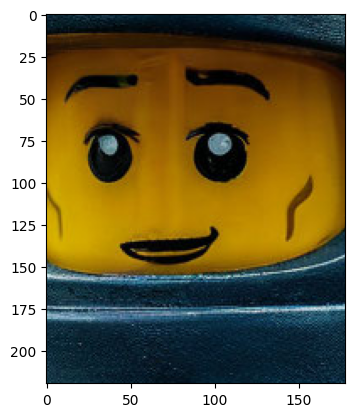

In [873]:
def plot_tensor(index):
    res = face_detector.get_coords_and_embeds(tensor_dataset[index])
    if res is not None:

        coords = res[0]
        
        for i in range(4):
            if coords[i] < 0:
                coords[i] = 0

        print(coords)

        x, y, x1, y1 = coords[0], coords[1], coords[2], coords[3]

        if x > x1:
            x, x1 = x1, x
        if y > y1:
            y, y1 = y1, y

        print(x, y, x1, y1)

        image = tensor_dataset[index]
        print(image.shape)
        image = image[:, int(y):int(y1), int(x):int(x1)]

        plt.imshow(image.permute(1, 2, 0))

plot_tensor(117)

In [803]:
def get_filtered_indexes(dataset: ImageDataset, percentile = 0.9):

    face_detected_indexes = []
    face_detected_embeddings = []

    for k in range(len(dataset)):
        res = face_detector.get_coords_and_embeds(tensor_dataset[k])
        if res is not None:
            face_detected_indexes.append(k)
            face_detected_embeddings.append(res[1])

        if k > 200:
            break

    face_detected_indexes = np.array(face_detected_indexes)
    face_detected_embeddings = np.array(face_detected_embeddings)

    face_detected_embeddings -= np.mean(face_detected_embeddings, axis=0)[None, :]
    face_detected_norms = np.linalg.norm(face_detected_embeddings, axis=1)

    face_detected_indexes = face_detected_indexes[np.argsort(face_detected_norms)]

    return face_detected_indexes[:int(percentile * face_detected_indexes.shape[0])]


get_filtered_indexes(tensor_dataset, percentile=0.75)

!!! 1
!!! 1
!!! 2
!!! 2
!!! 1
!!! 1
!!! 2
!!! 1
!!! 1
!!! 1
!!! 1
!!! 1
!!! 1
!!! 1
!!! 1
!!! 1


array([117,  74, 131,  14,  21, 120,  79,  18,  20,  22,  17,  64])